In [2]:
import xarray as xr
import numpy as np
from xgcm import Grid
from xgcm import apply_as_grid_ufunc
from xgcm import as_grid_ufunc

In [72]:
import matplotlib.pyplot as plt

In [19]:
ds = xr.Dataset(
    coords={
        "zl": (["zl"], np.arange(1,15)),
        "zi": (["zi"], np.arange(0.5, 15.5)),
        "xl": (["xl"], np.arange(1,15)),
        "xi": (["xi"], np.arange(0.5, 15.5)),
    }
)

grid_list = Grid(ds, 
            coords={"Z": {"center": 'zl', 'outer': 'zi'},
                    "X": {"center": 'xl', 'outer': 'xi'}},
           periodic=['X'])

grid_non_list = Grid(ds, 
            coords={"Z": {"center": 'zl', 'outer': 'zi'},
                    "X": {"center": 'xl', 'outer': 'xi'}},
           periodic='X')


In [20]:
grid_list

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   zl --> outer
  * outer    zi --> center
X Axis (periodic, boundary=None):
  * center   xl --> outer
  * outer    xi --> center

In [24]:
ds = xr.Dataset(
    coords={
        "zl": (["zl"], np.arange(1,15)),
        "zi": (["zi"], np.arange(0.5, 15.5))
    }
)

grid = Grid(ds, 
            coords={"Z": {"center": 'zl', 'outer': 'zi'}},
           periodic=False)

In [34]:
grid

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   zl --> outer
  * outer    zi --> center

In [32]:
temp = grid.cumsum(ds.zl, 'Z')
temp1 = grid.cumsum(ds.zl, 'Z', boundary='fill', fill_value=0.)

In [35]:
print(temp.values)
print(temp1.values)

[105   1   3   6  10  15  21  28  36  45  55  66  78  91 105]
[  0   1   3   6  10  15  21  28  36  45  55  66  78  91 105]


In [33]:
temp

<xarray.DataArray 'zl' (zi: 15)>
array([105,   1,   3,   6,  10,  15,  21,  28,  36,  45,  55,  66,  78,
        91, 105])
Coordinates:
  * zi       (zi) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 10.5 11.5 12.5 13.5 14.5

In [4]:
ds['u'] = np.sin(ds.zl * 2 * np.pi / 39)
ds['e'] = np.sin(ds.zi * 2 * np.pi / 5)

In [5]:
ds

<xarray.Dataset>
Dimensions:  (zl: 14, zi: 15)
Coordinates:
  * zl       (zl) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * zi       (zi) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 10.5 11.5 12.5 13.5 14.5
Data variables:
    u        (zl) float64 0.1604 0.3167 0.4647 0.6007 ... 0.935 0.866 0.7746
    e        (zi) float64 0.5878 0.9511 1.225e-16 ... 6.123e-16 -0.9511 -0.5878

In [10]:
@as_grid_ufunc("(Z:center),(Z:outer)->(Z:center)")
def multiply_upper(u, e): 
    return u * e[0:-1]

@as_grid_ufunc("(Z:center),(Z:outer)->(Z:center)")
def multiply_lower(u, e): 
    return u * e[1:None]


In [14]:
multiply_upper(grid, ds.u, ds.e, axis=[['Z'],['Z']])

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


<xarray.DataArray (zl: 14)>
array([ 9.42873852e-02,  3.01169159e-01,  5.69121745e-17, -5.71339845e-01,
       -4.23912162e-01,  4.83737779e-01,  8.59232423e-01,  3.52888629e-16,
       -9.44122243e-01, -5.87308557e-01,  5.75906496e-01,  8.89253290e-01,
        5.30287619e-16, -7.36693097e-01])
Coordinates:
  * zl       (zl) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14

In [75]:
ds_dens = xr.Dataset(
    coords={
        "zl": (["zl"], np.arange(26,28, 0.2)),
        "zi": (["zi"], np.arange(25.9, 28, 0.2))
    }
)

grid = Grid(ds_dens, 
            coords={"Z": {"center": 'zl', 'outer': 'zi'}},
           periodic=False)

ds_dens['vh'] = 0.*ds_dens.zl + 0.5


@as_grid_ufunc("(Z:center)->(Z:outer)")
def upward_sum(a):

    temp_zeros = np.zeros_like(a[...,0])[..., np.newaxis]

    temp = np.append(np.flip(np.cumsum(np.flip(a, axis=-1), axis=-1), axis=-1), temp_zeros, axis=-1)
    return temp

reg_cumsum = grid.cumsum(ds_dens.vh, 'Z', boundary='fill', fill_value=0.)
upward_cumsum = upward_sum(grid, ds_dens.vh, axis=['Z'])

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


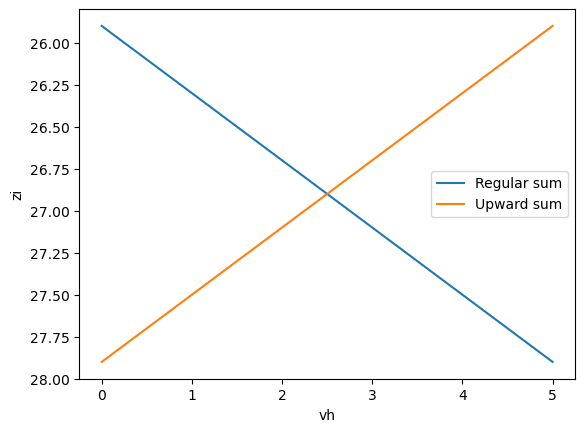

In [76]:
reg_cumsum.plot(y='zi',label='Regular sum')
upward_cumsum.plot(y='zi',label='Upward sum')
plt.gca().invert_yaxis()
plt.legend()